In [ ]:
!pip install pandas
!pip install seaborn
!pip install matplotlib
!pip install sklearn
!pip install --upgrade scikit-learn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def load_and_analyze(file_path):
    #Load the dataset and perform initial analysis.
    file_path = "/content/liver_cirrhosis.csv"
    file_name = "liver_cirrhosis.csv"
    df = pd.read_csv(file_path)
    print("----- Dataset Columns -----")
    print(df.columns.tolist())

    print("\n----- Dataset Shape -----")
    print(df.shape)

    print("\n----- First 5 Rows -----")
    print(df.head())

    print("\n----- Dataset Info -----")
    df.info()

    print("\n----- Statistical Description -----")
    print(df.describe())

    print("\n----- Missing Values per Column -----")
    print(df.isnull().sum())

    return df

In [ ]:
# Specify file path and target column name
file_path = "liver_cirrhosis_data.csv"
target_variable = "target_variable"  # update as needed
# ---------------- Dataset Analysis ----------------
df = load_and_analyze(file_path)

# Ensure target column exists; if not, use the last column as the target.
if target_variable not in df.columns:
   print(f"Warning: '{target_variable}' not found. Using last column as target.")
   target_variable = df.columns[-1]

----- Dataset Columns -----
['N_Days', 'Status', 'Drug', 'Age', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

----- Dataset Shape -----
(25000, 19)

----- First 5 Rows -----
   N_Days Status     Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0    2221      C  Placebo  18499   F       N            Y       N     N   
1    1230      C  Placebo  19724   M       Y            N       Y     N   
2    4184      C  Placebo  11839   F       N            N       N     N   
3    2090      D  Placebo  16467   F       N            N       N     N   
4    2105      D  Placebo  21699   F       N            Y       N     N   

   Bilirubin  Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  \
0        0.5        149.0     4.04   227.0     598.0   52.70           57.0   
1        0.5        219.0     3.93    22.0     663.0   45.00           75.0   
2     

In [ ]:
def convert_categorical(df, target):
    #Convert categorical columns (except the target) to numerical using one-hot encoding.
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    if target in cat_cols:
        cat_cols.remove(target)
    df_converted = pd.get_dummies(df, columns=cat_cols, drop_first=True)
    return df_converted

#Converting Categorical Data to Numerical
df = convert_categorical(df, target_variable)

In [ ]:
def scale_features(df, target):
    #Scale numeric features (excluding the target) using StandardScaler.
    df_scaled = df.copy()
    num_cols = df_scaled.select_dtypes(include=[np.number]).columns.tolist()
    if target in num_cols:
        num_cols.remove(target)

    scaler = StandardScaler()
    df_scaled[num_cols] = scaler.fit_transform(df_scaled[num_cols])
    return df_scaled

df_scaled = scale_features(df, target_variable)

In [ ]:
def create_regression_plots(df, target):
    #Create regression plots for every numeric feature (excluding the target) vs. target
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if target in numeric_cols:
        numeric_cols.remove(target)

    n_plots = len(numeric_cols)
    if n_plots == 0:
        return

    n_rows = (len(numeric_cols) + 1) // 2

    fig, axes = plt.subplots(n_rows, 2, figsize=(12, n_rows * 4))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.regplot(x=col, y=target, data=df, scatter_kws={'alpha': 0.5}, line_kws={'color': 'red'}, ax=axes[i])
        axes[i].set_title(f"{col} vs {target}")

    # Remove extra empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

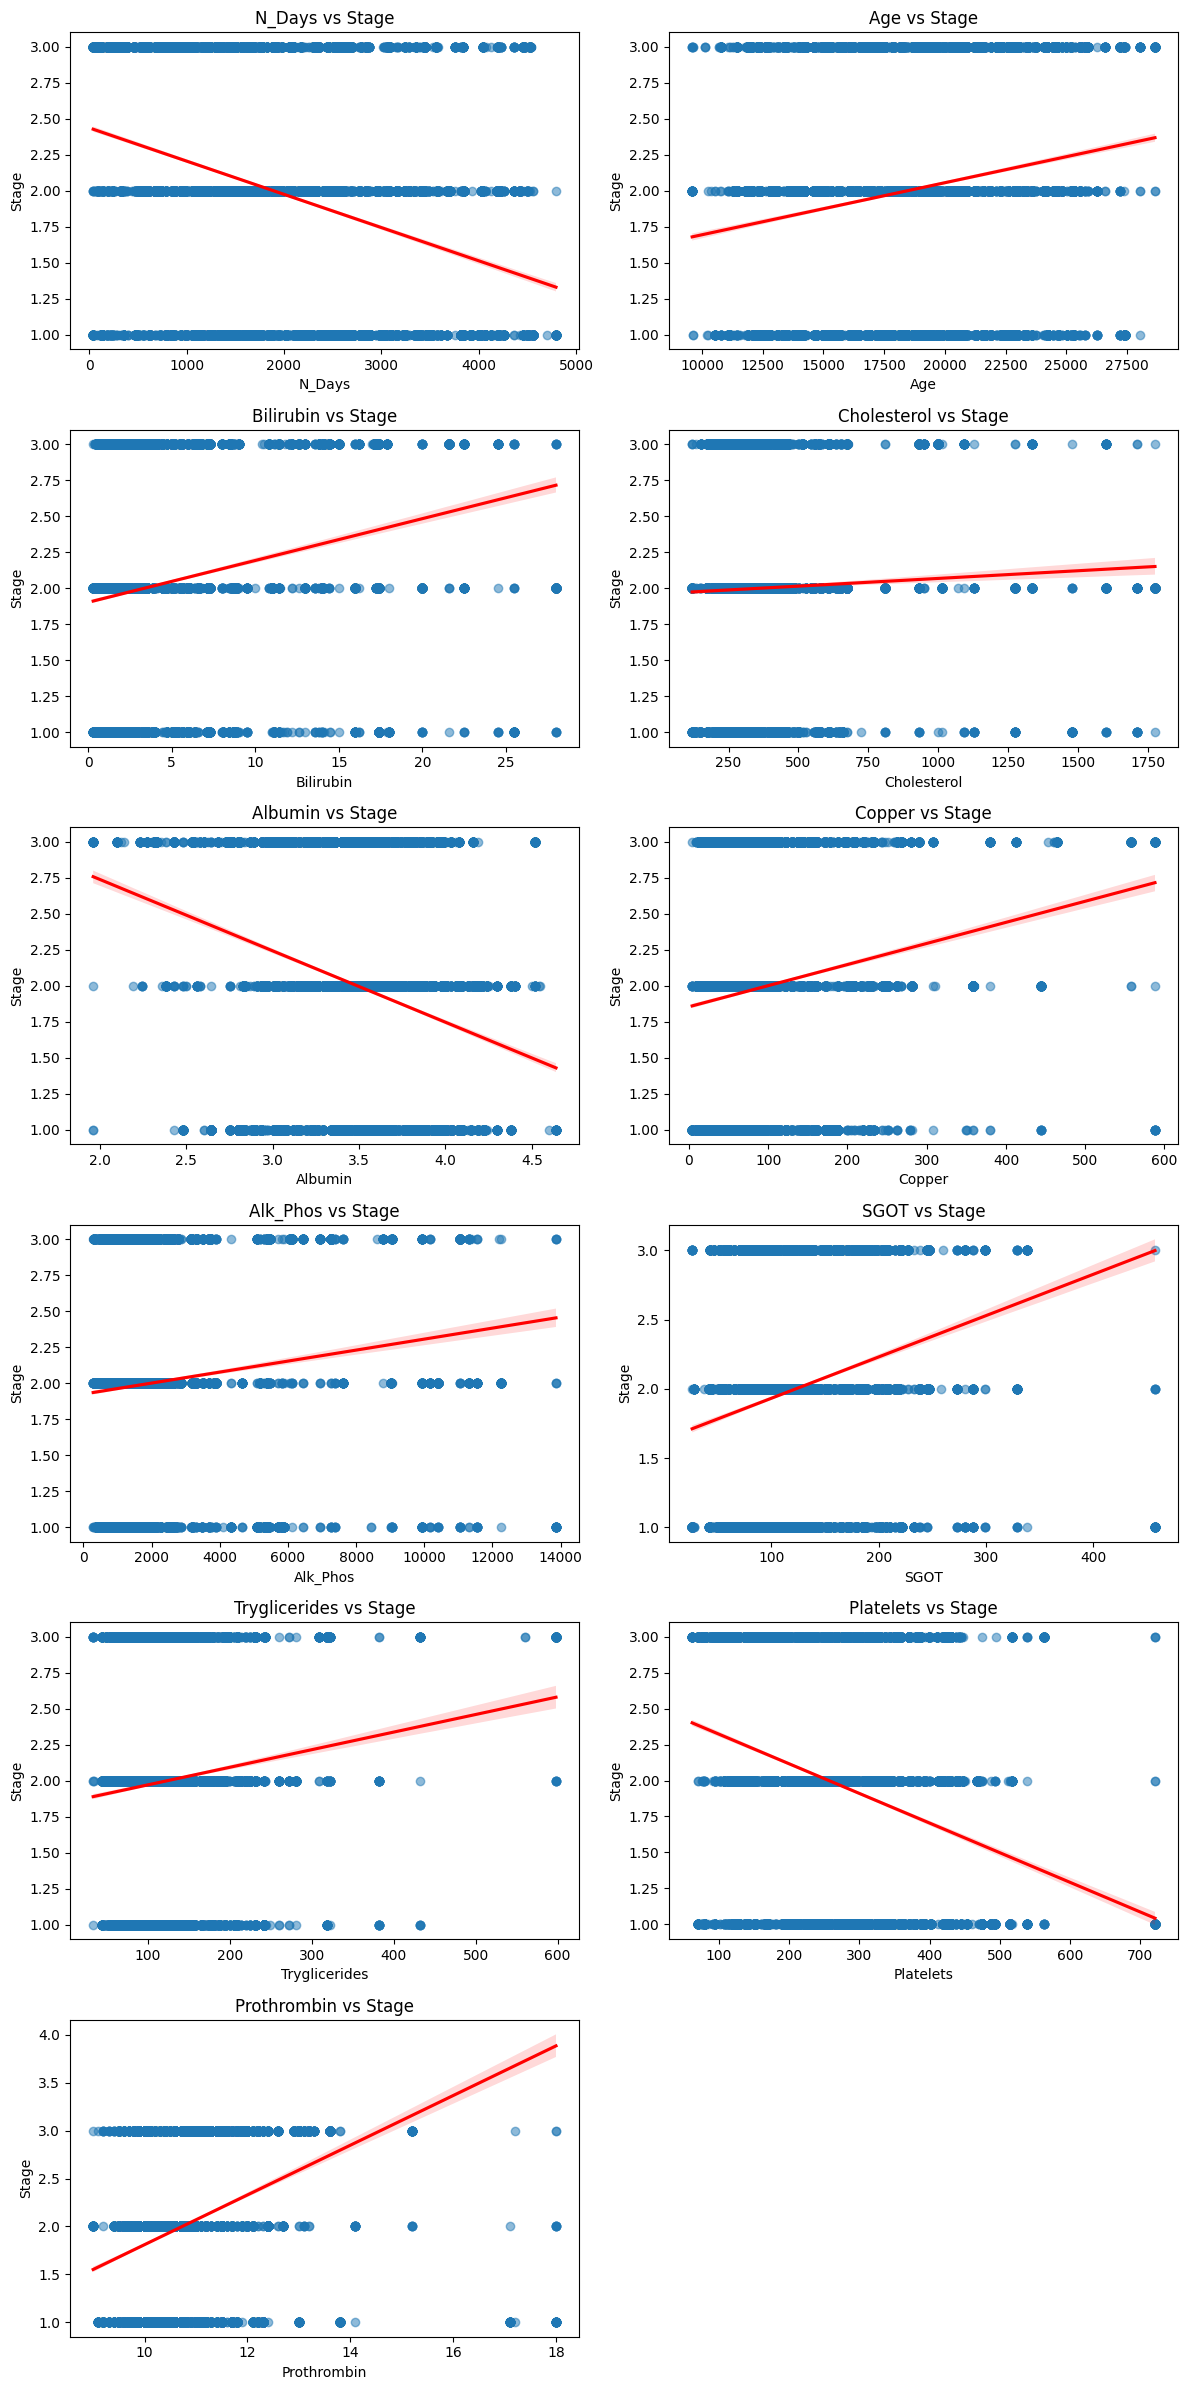

In [ ]:
create_regression_plots(df, target_variable)

In [ ]:
def plot_model_comparison(model_accuracies):
    #Plot a bar chart comparing model accuracies.
    models = list(model_accuracies.keys())
    accuracies = list(model_accuracies.values())

    plt.figure(figsize=(8, 6))
    sns.barplot(x=models, y=accuracies, palette="viridis")
    plt.title("Comparison of Model Accuracies")
    plt.ylabel("Accuracy")
    plt.ylim(0, 1)
    for index, acc in enumerate(accuracies):
        plt.text(index, acc + 0.02, f"{acc:.2f}", ha="center")
    plt.show()

In [ ]:
def plot_confusion_heatmaps(cms, titles):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), gridspec_kw={'wspace': 0.3})  # 3 heatmaps in one row with minimal gap

    for ax, cm, title in zip(axes, cms, titles):
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(title)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("Actual")

    plt.show()

In [ ]:
def split_data(df, target):
    #Split the data into training and testing sets.
    X = df.drop(columns=[target])
    y = df[target]
    stratify_arg = y if y.nunique() < 10 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1, stratify=stratify_arg
    )
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = split_data(df_scaled, target_variable)

In [ ]:
def logistic_regression_model(X_train, y_train, X_test, y_test):
    #Train and evaluate a Logistic Regression model.
    #Returns accuracy and the confusion matrix.
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    log_acc = accuracy_score(y_test, predictions)
    log_cm = confusion_matrix(y_test, predictions)
    print("----- Logistic Regression -----")
    print("Accuracy:", log_acc)
    print("Confusion Matrix:\n", log_cm)
    print("Classification Report:\n", classification_report(y_test, predictions))
    return log_acc, log_cm

log_acc, log_cm = logistic_regression_model(X_train, y_train, X_test, y_test)

----- Logistic Regression -----
Accuracy: 0.5998
Confusion Matrix:
 [[ 992  432  229]
 [ 524  814  350]
 [ 184  282 1193]]
Classification Report:
               precision    recall  f1-score   support

           1       0.58      0.60      0.59      1653
           2       0.53      0.48      0.51      1688
           3       0.67      0.72      0.70      1659

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



In [ ]:
def knn_model(X_train, y_train, X_test, y_test, n_neighbors=10):
    #Train and evaluate a KNN model.
    #Returns accuracy and the confusion matrix.
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    knn_acc = accuracy_score(y_test, predictions)
    knn_cm = confusion_matrix(y_test, predictions)
    print("----- KNN (n_neighbors=10) -----")
    print("Accuracy:", knn_acc)
    print("Confusion Matrix:\n", knn_cm)
    print("Classification Report:\n", classification_report(y_test, predictions))
    return knn_acc, knn_cm

knn_acc, knn_cm = knn_model(X_train, y_train, X_test, y_test)

----- KNN (n_neighbors=10) -----
Accuracy: 0.8816
Confusion Matrix:
 [[1461  142   50]
 [ 149 1478   61]
 [  72  118 1469]]
Classification Report:
               precision    recall  f1-score   support

           1       0.87      0.88      0.88      1653
           2       0.85      0.88      0.86      1688
           3       0.93      0.89      0.91      1659

    accuracy                           0.88      5000
   macro avg       0.88      0.88      0.88      5000
weighted avg       0.88      0.88      0.88      5000



In [ ]:
def random_forest_model(X_train, y_train, X_test, y_test, n_estimators=100, max_depth=12, random_state=0):
    #Train and evaluate a Random Forest model.
    #Returns accuracy and the confusion matrix.
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    rf_acc = accuracy_score(y_test, predictions)
    rf_cm = confusion_matrix(y_test, predictions)
    print("----- Random Forest -----")
    print("Accuracy:", rf_acc)
    print("Confusion Matrix:\n", rf_cm)
    print("Classification Report:\n", classification_report(y_test, predictions))
    return rf_acc, rf_cm

rf_acc, rf_cm = random_forest_model(X_train, y_train, X_test, y_test)

----- Random Forest -----
Accuracy: 0.9372
Confusion Matrix:
 [[1515  106   32]
 [  66 1581   41]
 [  19   50 1590]]
Classification Report:
               precision    recall  f1-score   support

           1       0.95      0.92      0.93      1653
           2       0.91      0.94      0.92      1688
           3       0.96      0.96      0.96      1659

    accuracy                           0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



<ipython-input-106-b853a6dd7538>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=accuracies, palette="viridis")


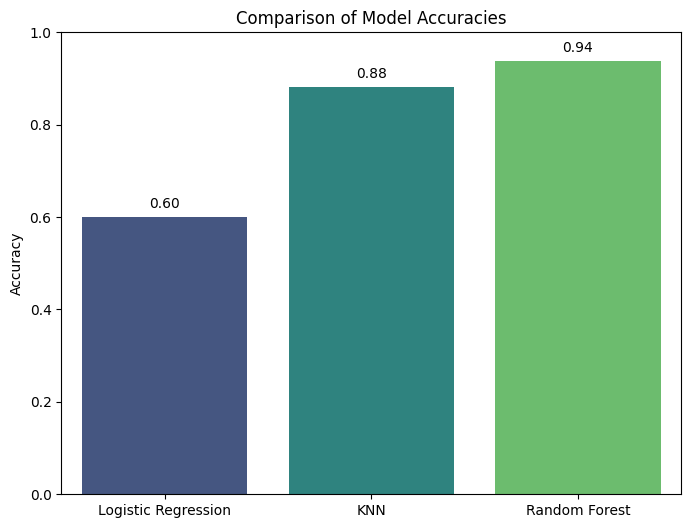

In [ ]:
# Models Comparison Bar Plot
model_accuracies = {
   "Logistic Regression": log_acc,
   "KNN": knn_acc,
   "Random Forest": rf_acc
}
plot_model_comparison(model_accuracies)

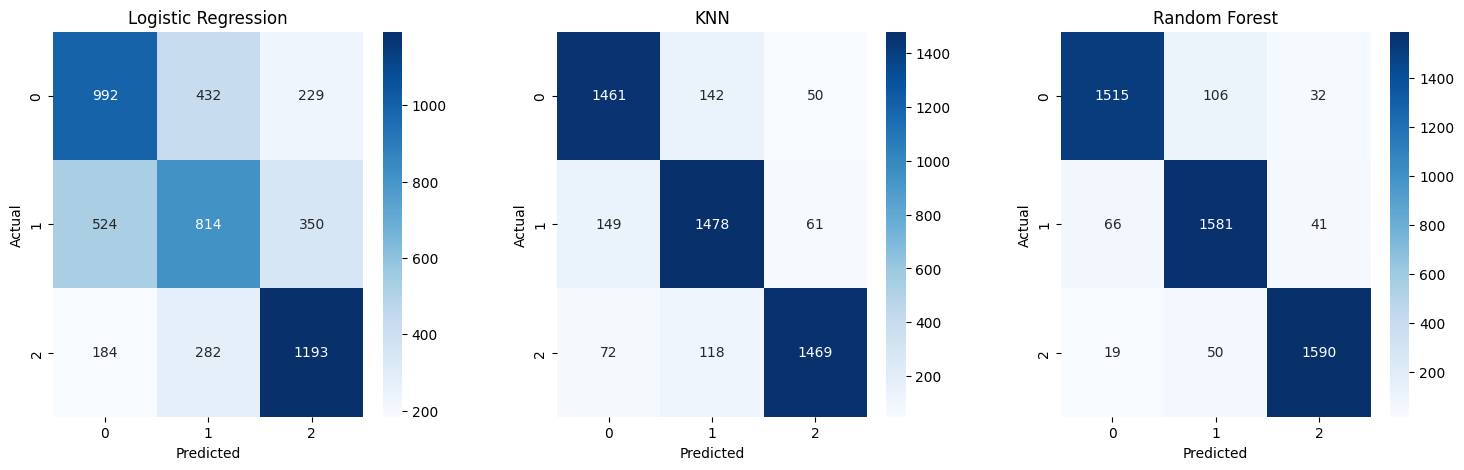

In [ ]:
plot_confusion_heatmaps([log_cm, knn_cm, rf_cm], ["Logistic Regression", "KNN", "Random Forest"])